In [2]:
!pip install scarches

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of xarray to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [3]:
!pip install scanpy

In [4]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown

 captum (see https://github.com/pytorch/captum).


In [5]:
url = 'https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0'
output = 'pbmc_tutorial.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0
From (redirected): https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0&confirm=t&uuid=a8c48ebf-404a-4732-a1ff-e7d41ea5d30f
To: /content/pbmc_tutorial.h5ad
100%|██████████| 231M/231M [00:04<00:00, 56.7MB/s]


'pbmc_tutorial.h5ad'

In [6]:
adata = sc.read('pbmc_tutorial.h5ad')


In [7]:
adata.X = adata.layers["counts"].copy()

In [8]:
url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
output = 'reactome.gmt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c
To: /content/reactome.gmt
100%|██████████| 331k/331k [00:00<00:00, 53.3MB/s]


'reactome.gmt'

In [9]:
sca.utils.add_annotations(adata, 'reactome.gmt', min_genes=12, clean=True)


In [10]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)


In [11]:
sc.pp.normalize_total(adata)

In [12]:
sc.pp.log1p(adata)


In [13]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [14]:
select_terms = adata.varm['I'].sum(0)>12

In [15]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()


In [16]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [17]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)


In [18]:
adata.X = adata.layers["counts"].copy()

In [19]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)



INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 4
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  282 0 0 4 1972
	with hard mask.
Last Decoder layer: softmax


In [20]:
ALPHA = 0.7

In [21]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=10,
    alpha_epoch_anneal=100,
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Preparing (32484, 1972)
Instantiating dataset
Init the group lasso proximal operator for the main terms.
 |████████████████████| 100.0%  - epoch_loss: 927.5916886642 - epoch_recon_loss: 901.0496759540 - epoch_kl_loss: 589.8225081665 - val_loss: 920.5266113281 - val_recon_loss: 895.8844581017 - val_kl_loss: 547.6034498948
Saving best state of network...
Best State was in Epoch 9


In [22]:
MEAN = False

In [23]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)

In [24]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [25]:
sc.tl.umap(adata)

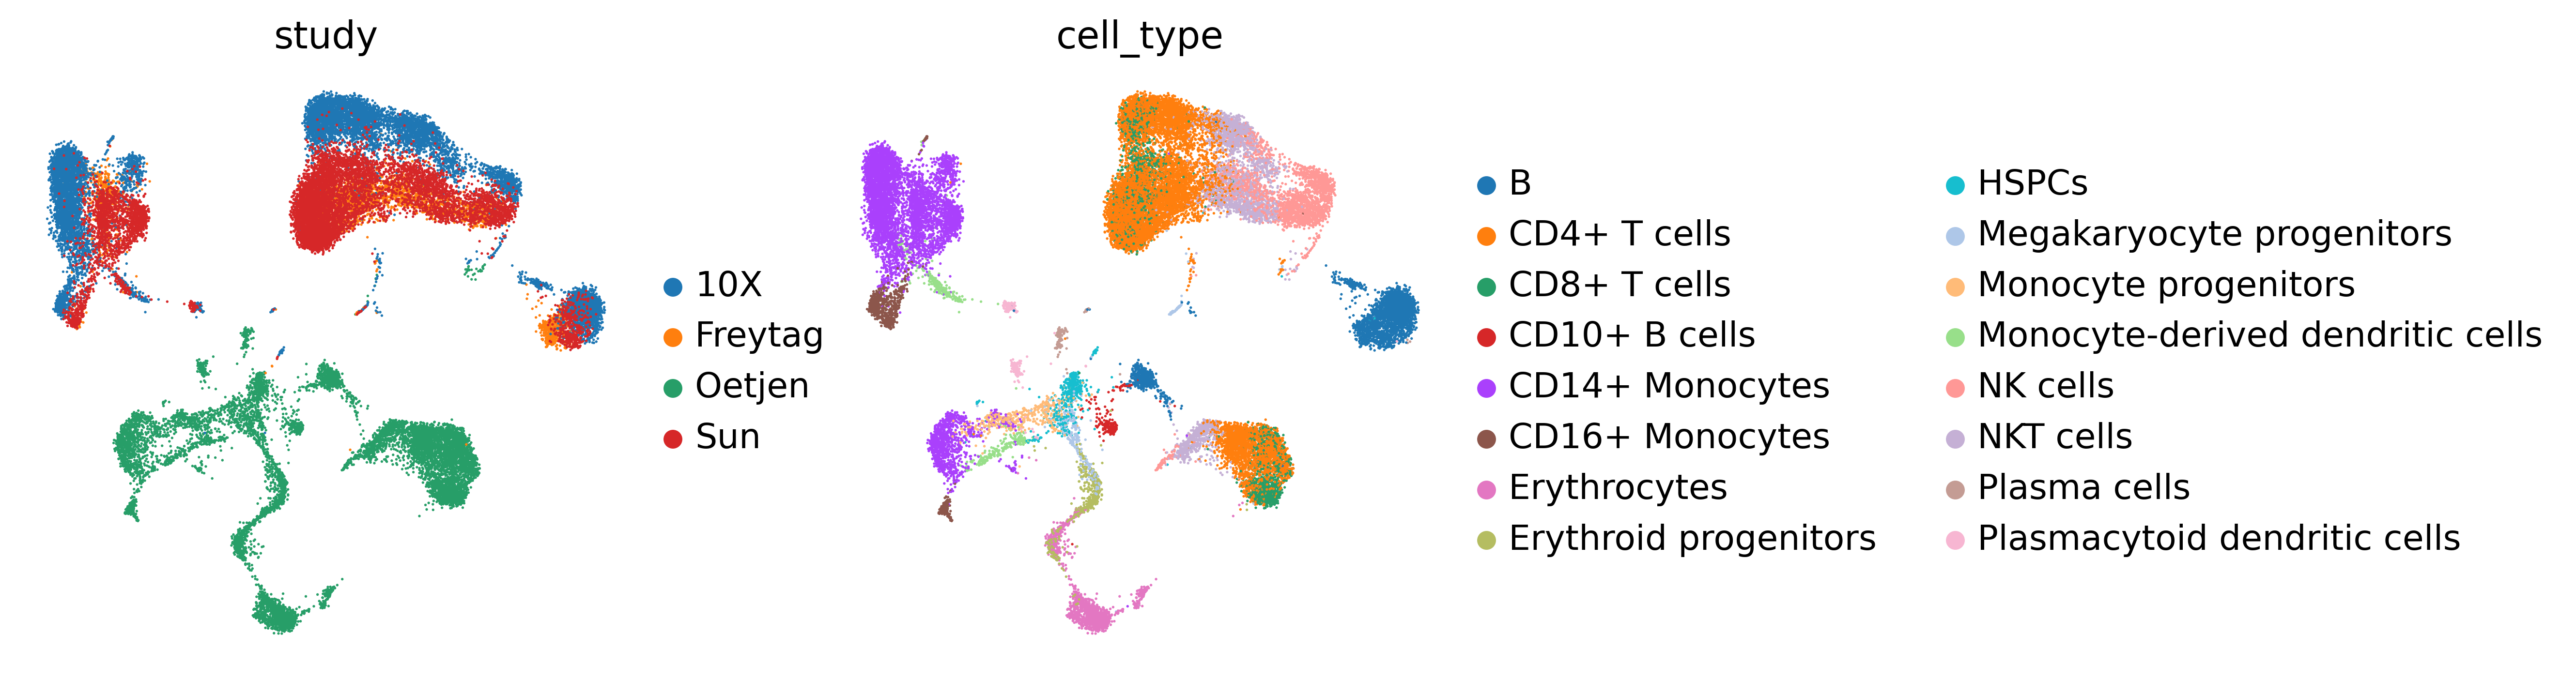

In [26]:
sc.pl.umap(adata, color=['study', 'cell_type'], frameon=False)


In [27]:
intr_cvae.latent_directions(adata=adata)


In [28]:
adata.obs

,batch,chemistry,data_type,dpt_pseudotime,final_annotation,mt_frac,n_counts,n_genes,sample_ID,size_factors,species,study,tissue,cell_type
index,,,,,,,,,,,,,,
AAACCTGCAGCGAACA-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,CD16+ Monocytes,0.047970,6379.0,1862.0,0,0.957719,Human,Oetjen,Bone_Marrow,CD16+ Monocytes
AAACCTGCATGTCCTC-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,CD4+ T cells,0.024928,4172.0,1082.0,0,0.425532,Human,Oetjen,Bone_Marrow,CD4+ T cells
AAACCTGGTCGACTGC-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,CD14+ Monocytes,0.051907,6608.0,1618.0,0,0.773111,Human,Oetjen,Bone_Marrow,CD14+ Monocytes
AAACCTGGTCGCTTCT-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,CD14+ Monocytes,0.041716,5034.0,1413.0,0,0.641188,Human,Oetjen,Bone_Marrow,CD14+ Monocytes
AAACCTGTCCCGACTT-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,NKT cells,0.043522,3998.0,1127.0,0,0.452426,Human,Oetjen,Bone_Marrow,NKT cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC,Sun_sample4_TC,10X,UMI,NaN,CD14+ Monocytes,0.059215,3006.0,1111.0,3,0.825529,Human,Sun,PBMCs,CD14+ Monocytes
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC,Sun_sample4_TC,10X,UMI,NaN,CD14+ Monocytes,0.051119,5810.0,1723.0,3,1.584353,Human,Sun,PBMCs,CD14+ Monocytes
TTTGTCATCATCATTC-1-Sun_sample4_TC,Sun_sample4_TC,10X,UMI,NaN,NK cells,0.038078,2705.0,1209.0,3,0.978014,Human,Sun,PBMCs,NK cells


In [29]:
intr_cvae.latent_enrich(groups='tissue', comparison='PBMCs', use_directions=True, adata=adata)

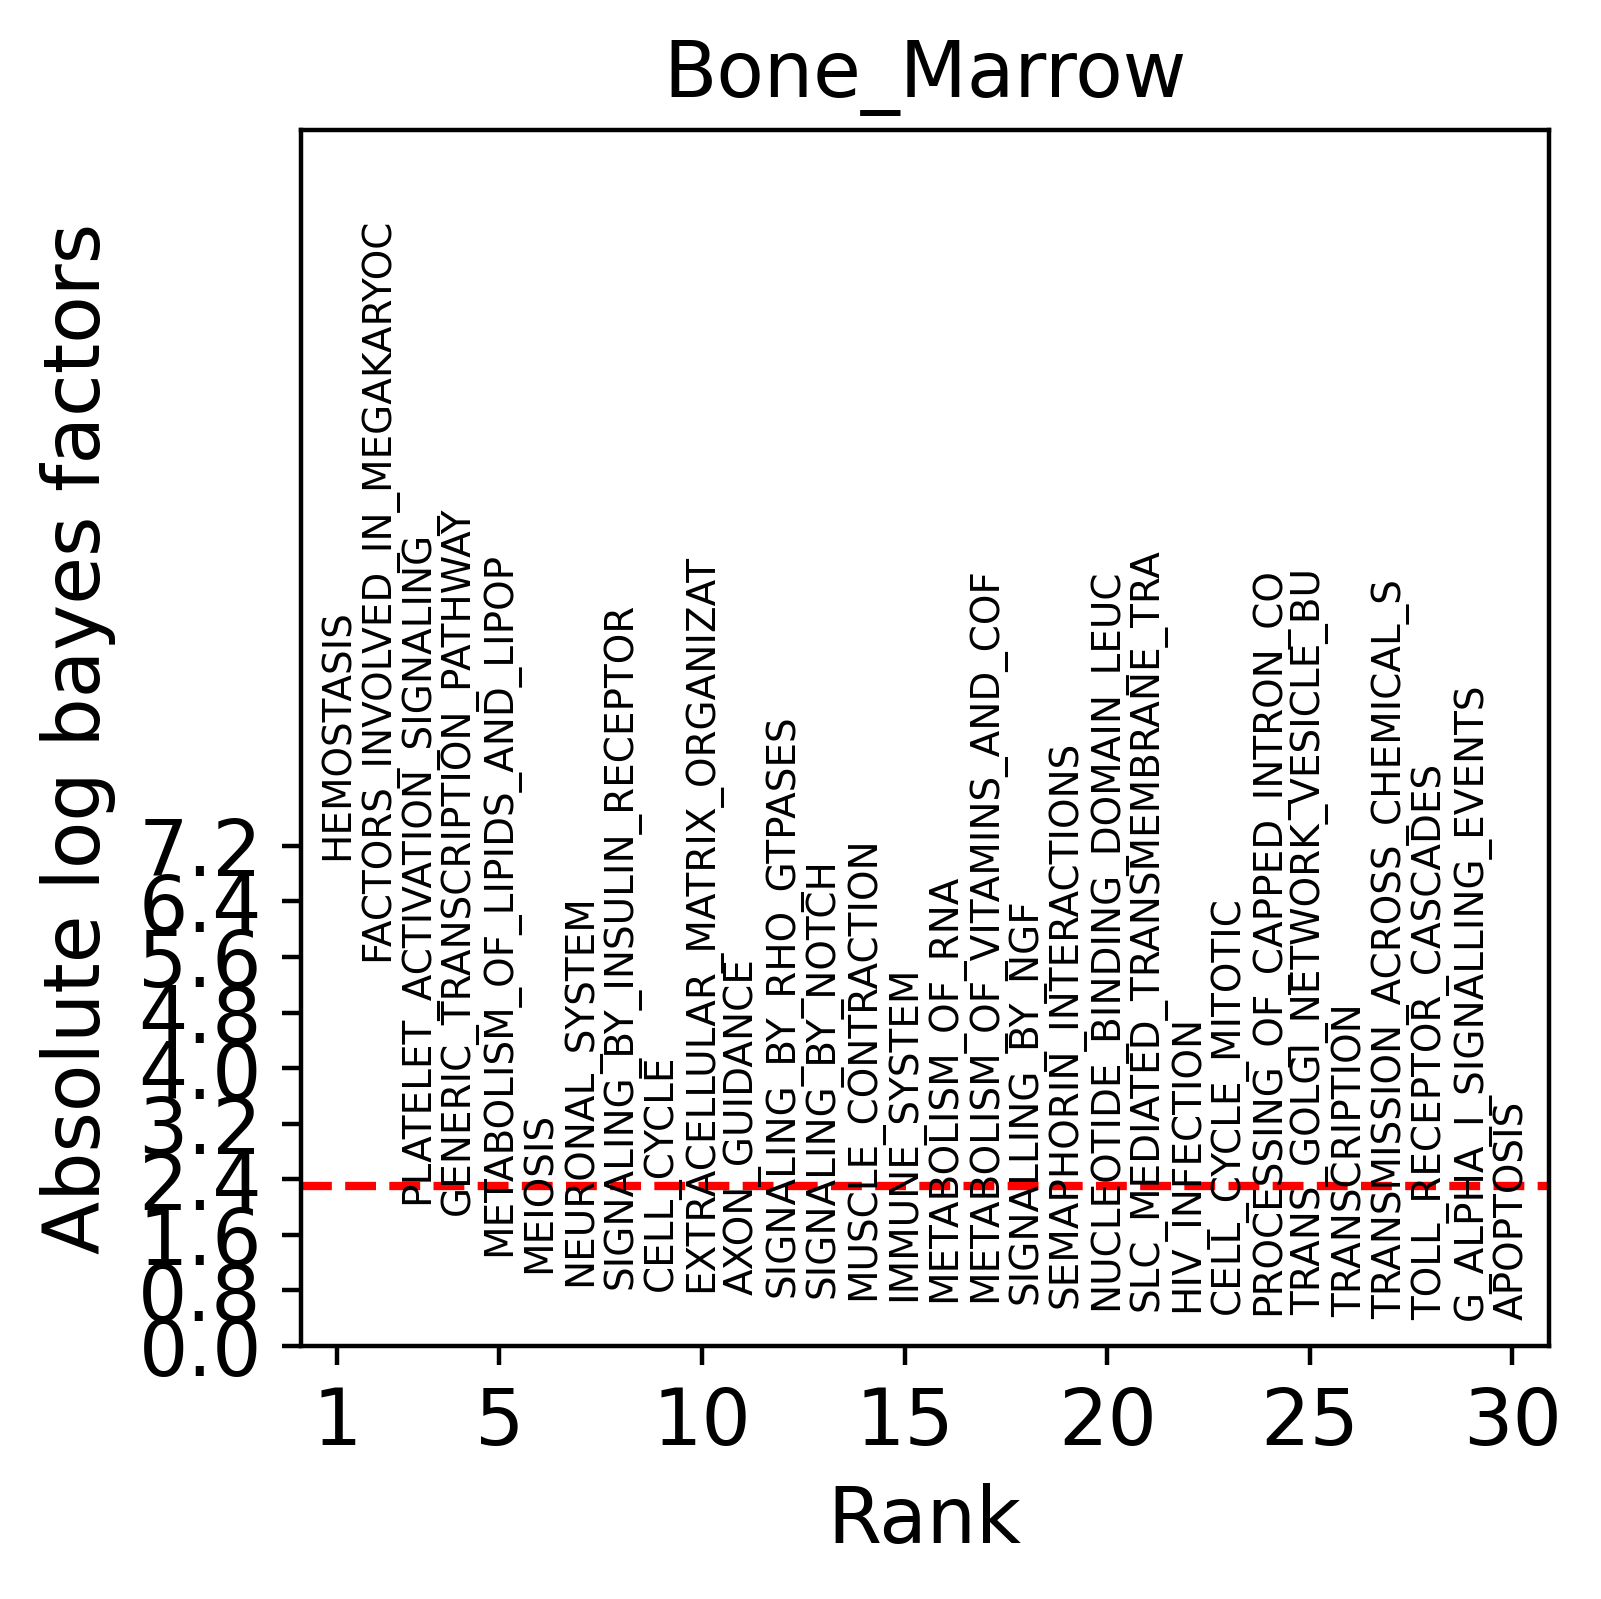

In [30]:
fig = sca.plotting.plot_abs_bfs(adata, yt_step=0.8, scale_y=2.5, fontsize=7)


In [31]:
terms = adata.uns['terms']
select_terms = ['INTERFERON_SIGNALING', 'INTERFERON_ALPHA_BETA_SIGNALIN', 'SIGNALING_BY_THE_B_CELL_RECEPT']
idx = [terms.index(term) for term in select_terms]

In [33]:
adata

AnnData object with n_obs × n_vars = 32484 × 1972
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'terms', 'log1p', 'hvg', 'neighbors', 'umap', 'study_colors', 'cell_type_colors', 'directions', 'bf_scores'
    obsm: 'X_cvae', 'X_umap'
    varm: 'I'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [34]:
latents = (intr_cvae.get_latent(adata.X, adata.obs['study'], mean=MEAN) * adata.uns['directions'])[:, idx]

In [36]:
adata.obs['INTERFERON_SIGNALING'] = latents[:, 0]
adata.obs['INTERFERON_ALPHA_BETA_SIGNALIN'] = latents[:, 1]

adata.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 2]

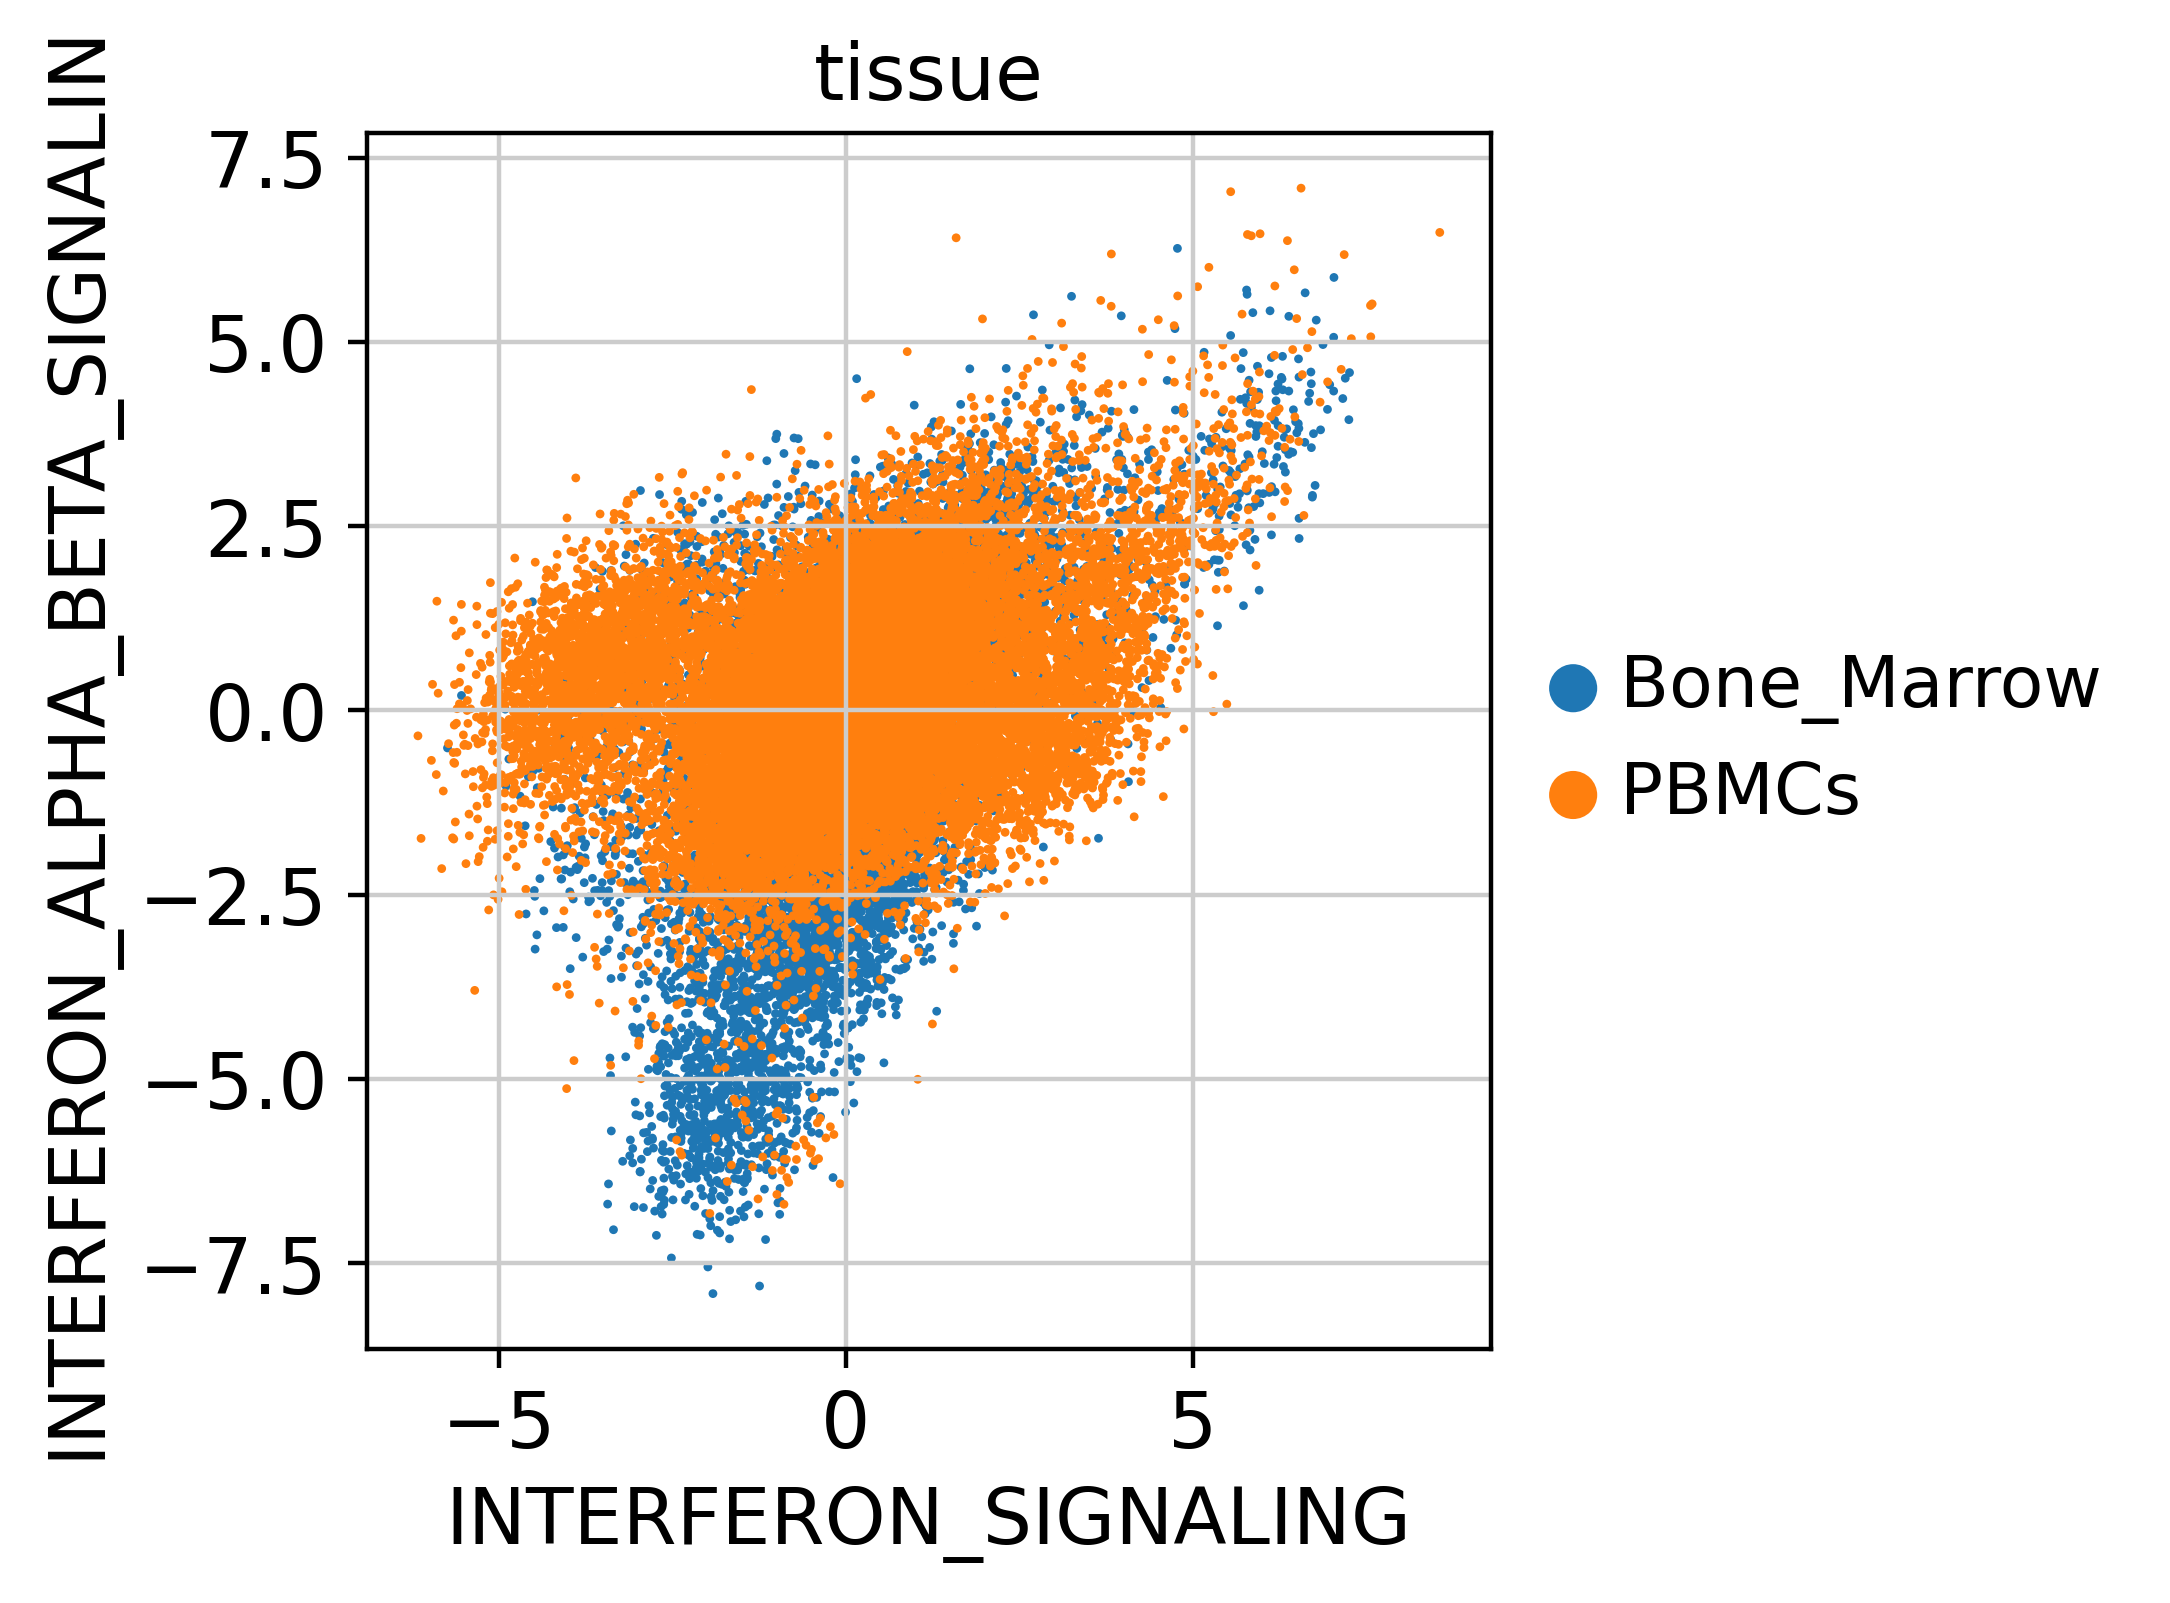

In [37]:
sc.pl.scatter(adata, x='INTERFERON_SIGNALING', y='INTERFERON_ALPHA_BETA_SIGNALIN', color='tissue', size=10)
